# Outlier explainability

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

import sqlalchemy as db
import pyodbc
import yaml

from scipy.stats import ttest_ind

In [2]:
sql = """
SELECT 
ps.[PRIMARY], 
ps.INSDATE,
ps.MA_NR,
ps.WSG_ID,
ps.WZD_ID,
ps.ST_ID,
ps.AT_ID,
ps.WZS_ID ,
ps.KOR_ID ,
ps.PUS_ID ,
IMAX_R,
IMAX_L,
IRMS_R,
IRMS_L,
IINT_R,
IINT_L,
IMAX_R_abHUB2,
IRMS_R_abHUB2,
IINT_R_abHUB2,
POSI_X,
POSI_Y,
POSI_Y_L,
POSI_Z,
ORD1_R,
ORD2_R,
ORDsum_R,
ORD1_L,
ORD2_L,
ORDsum_L,
ORDb_aR,
ORDz1_aR,
ORDz2_aR,
ORDsum_aR,
ORDAmax_aR,
ORDFmax_aR,
ORDb_aL,
ORDz1_aL,
ORDz2_aL,
ORDsum_aL,
ORDAmax_aL,
ORDFmax_aL,
AXIS_C_ACTIVE,
FORCE_FAKTOR,
APM_SCHL_Aktiv,
SCHLEIFZEIT,
IMAX_Xanfahrt,
NIO
FROM dbo.prozessmessung_schleifen ps 
WHERE WARM = 0
AND TEACH_ACTIVE = 0
AND READY = 1
AND MA_NR = 78635
AND WSG_ID IN (14)
AND WZD_ID IN (22)
AND ST_ID IN (20365)
AND AT_ID IN (80);
"""

In [3]:
db_config_file_path = 'C:/Users/Malwina/Desktop/Data_Science/capstone/db_config.yml'
db_config = yaml.safe_load(open(db_config_file_path))
engine = db.create_engine('{DB_DRIVER}://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}?driver={DB_ODBC_DRIVER}'.format(**db_config))

with engine.connect() as conn:
    df = pd.read_sql(sql=sql, con=conn)

In [5]:
df.head()

,PRIMARY,INSDATE,MA_NR,WSG_ID,WZD_ID,ST_ID,AT_ID,WZS_ID,KOR_ID,PUS_ID,...,ORDz2_aL,ORDsum_aL,ORDAmax_aL,ORDFmax_aL,AXIS_C_ACTIVE,FORCE_FAKTOR,APM_SCHL_Aktiv,SCHLEIFZEIT,IMAX_Xanfahrt,NIO
0,4309373,2020-09-22 18:36:31,78635,14,22,20365,80,115513,41433,20721,...,0.023187,7.883309,0.109575,92.773438,2,0.793936,0,28.921000,6.619385,0
1,4309374,2020-09-22 18:37:04,78635,14,22,20365,80,115513,41433,20721,...,0.021807,7.807761,0.113417,92.773438,1,0.793936,0,28.924000,6.675745,0
2,4309375,2020-09-22 18:37:40,78635,14,22,20365,80,115513,41433,20721,...,0.018045,7.759490,0.110169,92.773438,2,0.793936,0,28.938000,6.905995,0
3,4309376,2020-09-22 18:38:11,78635,14,22,20365,80,115513,41433,20721,...,0.017875,7.624981,0.107689,92.773438,1,0.793936,0,28.936001,6.911174,0
4,4309377,2020-09-22 18:38:46,78635,14,22,20365,80,115513,41433,20721,...,0.023899,7.700422,0.110605,92.773438,2,0.793936,0,28.922001,7.145072,0


In [4]:
lab = pd.read_csv('C:/Users/Malwina/Desktop/Data_Science/capstone/data/labels.csv')
lab.head()

,Unnamed: 0,PRIMARY,labels,scores
0,0,4303349,1,-0.426449
1,1,4303348,1,-0.427286
2,2,4303347,1,-0.420836
3,3,4303346,1,-0.437366
4,4,4303345,1,-0.422145


In [5]:
# joining the df with the labels
xdf = pd.concat([df, lab], axis=1)
xdf.head()

,PRIMARY,INSDATE,MA_NR,WSG_ID,WZD_ID,ST_ID,AT_ID,WZS_ID,KOR_ID,PUS_ID,...,AXIS_C_ACTIVE,FORCE_FAKTOR,APM_SCHL_Aktiv,SCHLEIFZEIT,IMAX_Xanfahrt,NIO,Unnamed: 0,PRIMARY,labels,scores
0,4303349,2020-09-17 14:18:12,78635,14,22,20365,80,115450,41426,20721,...,2,0.948922,0,28.851,8.523942,0,0,4303349,1,-0.426449
1,4303348,2020-09-17 14:17:42,78635,14,22,20365,80,115450,41426,20721,...,1,0.948922,0,28.879,8.852757,0,1,4303348,1,-0.427286
2,4303347,2020-09-17 14:17:06,78635,14,22,20365,80,115450,41426,20721,...,2,0.948922,0,28.865,8.861331,0,2,4303347,1,-0.420836
3,4303346,2020-09-17 14:16:35,78635,14,22,20365,80,115450,41426,20721,...,1,0.948922,0,28.864,8.947095,0,3,4303346,1,-0.437366
4,4303345,2020-09-17 14:16:00,78635,14,22,20365,80,115450,41426,20721,...,2,0.948922,0,28.861,8.156557,0,4,4303345,1,-0.422145


In [6]:
to_drop = ['MA_NR', 'WSG_ID', 'WZD_ID', 'ST_ID', 'AT_ID', 'WZS_ID', 'PUS_ID', 'Unnamed: 0', 'NIO', 'KOR_ID']
xdf = xdf.drop(to_drop, 1)
xdf.head()

,PRIMARY,INSDATE,IMAX_R,IMAX_L,IRMS_R,IRMS_L,IINT_R,IINT_L,IMAX_R_abHUB2,IRMS_R_abHUB2,...,ORDAmax_aL,ORDFmax_aL,AXIS_C_ACTIVE,FORCE_FAKTOR,APM_SCHL_Aktiv,SCHLEIFZEIT,IMAX_Xanfahrt,PRIMARY,labels,scores
0,4303349,2020-09-17 14:18:12,16.470819,11.36455,16.46969,11.36420,77.477318,85.870842,16.08637,16.085991,...,0.146944,92.773438,2,0.948922,0,28.851,8.523942,4303349,1,-0.426449
1,4303348,2020-09-17 14:17:42,16.027140,11.40809,16.02545,11.40770,77.852478,86.127457,16.14307,16.142481,...,0.155637,92.773438,1,0.948922,0,28.879,8.852757,4303348,1,-0.427286
2,4303347,2020-09-17 14:17:06,15.635400,11.34007,15.63438,11.33987,76.748596,85.745361,15.91887,15.918390,...,0.139630,92.773438,2,0.948922,0,28.865,8.861331,4303347,1,-0.420836
3,4303346,2020-09-17 14:16:35,15.932110,11.41029,15.93077,11.40987,77.431900,85.627159,15.98563,15.985290,...,0.152977,92.773438,1,0.948922,0,28.864,8.947095,4303346,1,-0.437366
4,4303345,2020-09-17 14:16:00,15.728010,11.25792,15.72661,11.25767,75.356918,85.330254,15.97593,15.975170,...,0.146070,92.773438,2,0.948922,0,28.861,8.156557,4303345,1,-0.422145


In [7]:
sensors = ['IMAX_R',
'IMAX_L',
'IRMS_R',
'IRMS_L',
'IINT_R',
'IINT_L',
'IMAX_R_abHUB2',
'IRMS_R_abHUB2',
'IINT_R_abHUB2',
'POSI_X','POSI_Y','POSI_Y_L','POSI_Z',
'ORD1_R',
'ORD2_R',
'ORDsum_R',
'ORD1_L',
'ORD2_L',
'ORDsum_L',
'ORDb_aR',
'ORDz1_aR',
'ORDz2_aR',
'ORDsum_aR',
'ORDAmax_aR',
'ORDFmax_aR',
'ORDb_aL',
'ORDz1_aL',
'ORDz2_aL',
'ORDsum_aL',
'ORDAmax_aL',
'ORDFmax_aL',
'AXIS_C_ACTIVE',
'FORCE_FAKTOR',
'APM_SCHL_Aktiv',
'SCHLEIFZEIT',
'IMAX_Xanfahrt']

In [10]:
len(sensors)

36

C:\Users\Malwina\anaconda3\envs\process-optimization\lib\site-packages\pandas\plotting\_matplotlib\hist.py:387: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(
C:\Users\Malwina\anaconda3\envs\process-optimization\lib\site-packages\pandas\plotting\_matplotlib\hist.py:387: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(
C:\Users\Malwina\anaconda3\envs\process-optimization\lib\site-packages\pandas\plotting\_matplotlib\hist.py:387: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(
C:\Users\Malwina\anaconda3\envs\process-optimization\lib\site-packages\pandas\plotting\_matplotlib\hist.py:387: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(
C:\Users\Malwina\anaconda3\envs\process-optimization\lib\site-packag

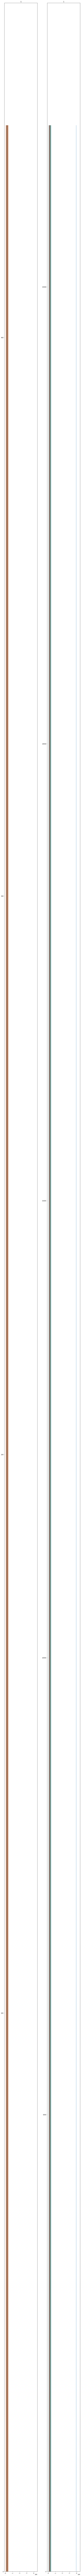

In [42]:
len(sensors)

36

In [45]:
features = {'sensors': sensors, 'pvalue': pvalues}
feature_imp = pd.DataFrame(features)
feature_imp.sort_values(by=['pvalue'])
  
""" 6 most imp features based on pvalue of outliers (welch's test):
    IINT_R_abHUB2 	9.815622e-135
	IRMS_R_abHUB2 	7.741966e-127
	IMAX_R_abHUB2 	7.781149e-127
    IINT_R 	5.567697e-101
 	IRMS_R 	7.457370e-98
	IMAX_R 	7.533073e-98
    """

,sensors,pvalue
8,IINT_R_abHUB2,9.815622e-135
7,IRMS_R_abHUB2,7.741966e-127
6,IMAX_R_abHUB2,7.781149e-127
4,IINT_R,5.567697e-101
2,IRMS_R,7.457370e-98
0,IMAX_R,7.533073e-98
1,IMAX_L,8.128061e-94
3,IRMS_L,8.227713e-94
5,IINT_L,5.737088e-87
33,APM_SCHL_Aktiv,4.441418e-77


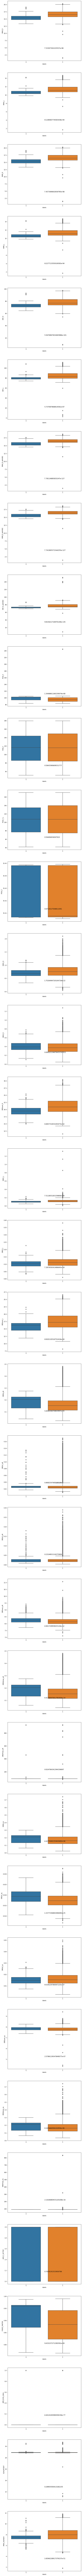

In [38]:
n = len(sensors)
fig, axs = plt.subplots(n, 1, figsize=(10, 10*n))
pvalues=[]
for i, sensor in enumerate(sensors):
    #ttest_ind = welch's test, p < 0.05 they are different
    T_score = (ttest_ind(xdf[sensor].loc[xdf['labels']==1], xdf[sensor].loc[xdf['labels']==-1], equal_var=False))[1]
    pvalues.append(T_score)
    ax=axs[i]
    sns.boxplot(x='labels', y=sensor, ax=ax, data=xdf)
    ax.text(0.5, 0.2, T_score, fontsize=12, transform=ax.transAxes)
    

# Histograms

In [35]:
# adding weight to the outliers better visualize them 
x_weights = np.where(xdf['labels'].values < 0, 50, 1)
xdf['weights'] = x_weights

,PRIMARY,INSDATE,IMAX_R,IMAX_L,IRMS_R,IRMS_L,IINT_R,IINT_L,IMAX_R_abHUB2,IRMS_R_abHUB2,...,ORDFmax_aL,AXIS_C_ACTIVE,FORCE_FAKTOR,APM_SCHL_Aktiv,SCHLEIFZEIT,IMAX_Xanfahrt,PRIMARY,labels,scores,weights
0,4303349,2020-09-17 14:18:12,16.470819,11.36455,16.46969,11.36420,77.477318,85.870842,16.08637,16.085991,...,92.773438,2,0.948922,0,28.851,8.523942,4303349,1,-0.426449,1
1,4303348,2020-09-17 14:17:42,16.027140,11.40809,16.02545,11.40770,77.852478,86.127457,16.14307,16.142481,...,92.773438,1,0.948922,0,28.879,8.852757,4303348,1,-0.427286,1
2,4303347,2020-09-17 14:17:06,15.635400,11.34007,15.63438,11.33987,76.748596,85.745361,15.91887,15.918390,...,92.773438,2,0.948922,0,28.865,8.861331,4303347,1,-0.420836,1
3,4303346,2020-09-17 14:16:35,15.932110,11.41029,15.93077,11.40987,77.431900,85.627159,15.98563,15.985290,...,92.773438,1,0.948922,0,28.864,8.947095,4303346,1,-0.437366,1
4,4303345,2020-09-17 14:16:00,15.728010,11.25792,15.72661,11.25767,75.356918,85.330254,15.97593,15.975170,...,92.773438,2,0.948922,0,28.861,8.156557,4303345,1,-0.422145,1


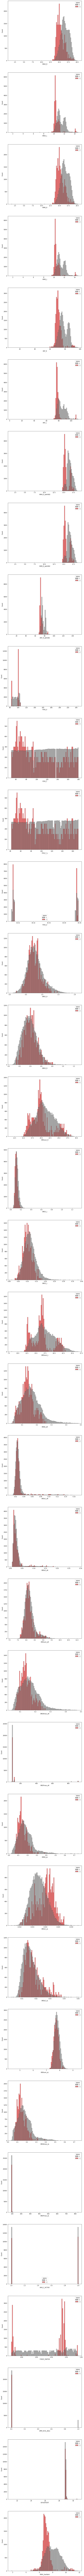

In [36]:
# plotting histograms
n = len(sensors)
fig, axs = plt.subplots(n, 1, figsize=(10, 10*n))
x_weights = np.where(xdf['labels'].values < 0, 100, 1)
for i, sensor in enumerate(sensors):

    ax=axs[i]
    sns.histplot(data=xdf, x=sensor, hue='labels', hue_order= [1, -1], palette=['grey', 'red'], 
                weights='weights', bins=100,
                    ax=ax)
# Add quantitative distance mesures like      or  Kolmogorov–Smirnov test